In [1]:
import warnings
import sys
warnings.simplefilter('ignore')
sys.path.append('/Users/nagataeiki/.pyenv/versions/3.7.4/lib/python3.7/site-packages')


In [2]:
import pandas as pd
bad = pd.read_csv('../data/clean/cleaned_bad.csv')
normal=pd.read_csv('../data/clean/cleaned_normal.csv')
# hiniku_=pd.read_csv('../data/hiniku/hiniku_with_word.csv')
hiniku = pd.read_csv("../data/clean/cleaned_hiniku.csv")
df = pd.read_csv('../data/clean/mount_all_data.csv')
# df.drop('comment_id', axis=1, inplace=True)

In [3]:
badwordlist = pd.read_csv('../data/clean/mount_bad_list.csv')
from janome.tokenizer import Tokenizer

tokenizer=Tokenizer()
badwordlist_reading = []
for word  in badwordlist.bad.values:
    text=""
    for t in tokenizer.tokenize(word):
        if t.reading=="*":
            pass
        else:
            text+=t.reading
    if len(text)>=1:
        badwordlist_reading.append(text)
# pd.DataFrame(badwordlist_reading).to_csv('../data/clean/badwordlist_reading.csv', index=False)

In [4]:
# badwordlist

In [44]:
from sklearn.svm import SVR
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


def train_and_pred(df, threshold=0.5):
    df = df.copy()
    df = df.dropna()
    # testdf.target = testdf.target.apply(lambda x: 0 if x==0 else 1)#x==0(ニュートラル)の時0, その他は1
    df.target = df.target.apply(lambda x: 0 if x==1 else 1)#x==1(悪口)の時0, その他は1 [0:悪口, 1:その他]
    # testdf.target = testdf.target.apply(lambda x: 0 if x==2 else 1)#x==2(皮肉)の時0, その他は1
    df.target.unique()
    df.target.unique()
    X = df.drop("target",axis=1)#.drop('content', axis=1)
    y=df.target
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)    
    
    svm = SVR()
    svm.fit(x_train.drop(['content'], axis=1), y_train)
    pred_train = svm.predict(x_train.drop(['content'], axis=1))
    pred_test = svm.predict(x_test.drop(['content'], axis=1))

    print("train")

    pred_train = [1 if x>threshold else 0 for x in pred_train]
    pred_test = [1 if x>threshold else 0 for x in pred_test]
    print("f1: " ,f1_score(y_train, pred_train))
    display(create_2x2_matrix(y_train, pred_train))
    # print_2x2_miss_pred(y_train, pred_train,x_train)
    print('------------------------------------------------------------------')
    print('test')

    print("f1: ",f1_score(y_test, pred_test))
    display(create_2x2_matrix(y_test, pred_test))
    train_miss = print_2x2_miss_pred(y_train, pred_train,x_train)
    test_miss =  print_2x2_miss_pred(true_y=y_test, pred_y=pred_test,df=x_test)
    return {
        "miss_train_df":train_miss, 
        "miss_test_df":test_miss,
        "x_train":x_train,
        "y_train":y_train,
        "x_test":x_test,
        "y_test":y_test,
        "pred_train":pred_train,
        "pred_test":pred_test
    }

In [5]:
def create_2x2_matrix(true_y, pred_y):
    matrix = np.zeros(4)

    for t,p in zip(true_y, pred_y):
        if t==0:
            if p==0:matrix[0]+=1
            if p==1:matrix[1]+=1
        elif t==1:
            if p==0:matrix[2]+=1
            if p==1:matrix[3]+=1
    return matrix.reshape(2,2)


In [6]:
def print_2x2_miss_pred(true_y, pred_y,df, test=True):
    def print_str_label(num):
        if num==1:return "悪口"
        if num==0:return "皮肉or その他"
        return np.nan

    idx_arr = []
    pred_judge=[]
    true_judge=[]
    col=["content", "pred_idx", "pred_label","true_idx", "true_label"]
    returndf = pd.DataFrame(columns=col)
    for i in range(len(df)):
        if pred_y[i]!=true_y.values[i]:
            tmpdf = pd.DataFrame(np.array([df.iloc[i].content, pred_y[i], print_str_label(pred_y[i]),\
                                            true_y.values[i], print_str_label(true_y.values[i])]).reshape(1,-1), \
                                              columns=col)
            returndf = pd.concat([returndf, tmpdf])
    return returndf


def print_2x2_correct_pred(true_y, pred_y,df, test=True):
    def print_str_label(num):
        if num==1:return "悪口"
        if num==0:return "皮肉or その他"
        return np.nan

    idx_arr = []
    pred_judge=[]
    true_judge=[]
    col=["content", "pred_idx", "pred_label","true_idx", "true_label"]
    returndf = pd.DataFrame(columns=col)
    for i in range(len(df)):
        if pred_y[i]==true_y.values[i]:
            tmpdf = pd.DataFrame(np.array([df.iloc[i].content, pred_y[i], print_str_label(pred_y[i]),\
                                            true_y.values[i], print_str_label(true_y.values[i])]).reshape(1,-1), \
                                              columns=col)
            returndf = pd.concat([returndf, tmpdf])
    return returndf

In [7]:
def create_wakati_content(text):
    wakati = []
    for t in tokenizer.tokenize(text):
        wakati.append(t.surface)
    return wakati

In [8]:
from gensim.models import Word2Vec
from tqdm import tqdm
# data = pd.read_csv('../data/clean/mount_bad_list.csv')
data = pd.read_csv("../data/clean/mount_all_data.csv")
data = data[data.type==1]
wakati_arr = []
for r in tqdm(data.iterrows()):
    wakati = create_wakati_content(r[1].content)
    wakati_arr.append(wakati)
model = Word2Vec(wakati_arr, sg=1, size=100, window=5, min_count=1)


932it [00:02, 330.80it/s]


In [9]:
data = pd.read_csv('../data/some_comment_data.csv')

for r in tqdm(data.iterrows()):
    wakati = create_wakati_content(r[1].content)
    wakati_arr.append(wakati)
model = Word2Vec(wakati_arr, sg=1, size=100, window=5, min_count=1)


100001it [02:30, 665.38it/s]


In [10]:
'''
悪口ワードの含有
皮肉ワードの含有
ポジティブワードの含有

[形態素解析した時の単語数],[単純に悪口単語が文章に含まれているのかのフラグ], [形態素ごとに現れる悪口数]
[皮肉単語が含まれているかのフラグ],[形態素ごとに現れる皮肉数]
[ポジティブな単語が含まれているかのフラグ], [形態素ごとに現れるポジティブ単語数]

'''
import pandas as pd
# df = bad.copy()
# df = pd.concat([hiniku_, normal])
# df = pd.concat([bad, df])
import sys
import numpy as np
from janome.tokenizer import Tokenizer
from tqdm import tqdm
import gensim

df = pd.read_csv('../data/clean/mount_all_data.csv')
df.drop('comment_id', axis=1, inplace=True)
tokenizer = Tokenizer()
#悪口が含まれている数のカウント, 単に含まれているのかのフラグを返す
def get_word_count(text, wordlist):
    textlist = []
    count=0
    flg=0
    for t in tokenizer.tokenize(text):
        if t.surface in wordlist:
            count+=1
    for w in wordlist:
        if w in text:
            flg=1
            return count, flg
    
    return count,flg


def get_order_label(text):
    for t in tokenizer.tokenize(text):
        if t.infl_form[:2]=="命令":
            return 1
    return 0



def cos_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


'''
###ここを実行することでword2vecのモデル作成
from gensim.models import Word2Vec
data = pd.read_csv('../data/some_comment_data.csv')
newdata=pd.concat([pd.DataFrame(data.content), pd.DataFrame(df.content)])
wakati_arr = []
for r in tqdm(newdata.iterrows()):
    wakati = create_wakati_content(r[1].content)
    wakati_arr.append(wakadti)
model = Word2Vec(wakati_arr, sg=1, size=100, window=5, min_count=1)
'''

def calc_cosine_similary(text,model,debug=False):
    text_list = []
    scores = {}

    for t in tokenizer.tokenize(text):
        text_list.append(t.surface)
    for word in text_list:
        try:
            vector1 = model.wv[word]
            scores[word] = []
            for bad in bad_list:
                try:
                    vector2 = model.wv[bad]
                    score = cos_similarity(vector1,vector2)
                    scores[word].append(score)
                except :
                    pass
        except:
            pass
    all_scores = []
    for scores in scores.values():
        all_scores +=scores
    all_scores= np.array(all_scores)
    typicalV = np.median(all_scores, axis=0)

    if debug:
        return scores
    return typicalV


def mophologicize(text):
    words = []
    for t in tokenizer.tokenize(text):
        words.append(t.surface)    
    return words


#dfと悪口辞書を入れて新しい特徴量を含んだdfを返す
def make_features(df, badwordlist, positivelist=np.nan, hinikulist=np.nan):
#     col=["content","mophologics_num", "bad_per_mophologic", "simple_bad_flg","target", "hiniku_per_mophologic",\
#          "simple_hiniku_flg", "positive_per_mophologic", "simple_positive_flg"]
#     import gensim
#     PATH="./gensimmodel/word2vec.gensim.model"
#     model = gensim.models.Word2Vec.load(PATH)
    col=["content","mophologics_num", "bad_count_in_mophologic", "simple_bad_flg","target","order","mophologic_content"]

    basedf = pd.DataFrame(columns=col)
    tokenizer = Tokenizer()
    for r in tqdm(df.iterrows()):
        text = str(r[1].content)
        target = r[1].type
        num = len(tokenizer.tokenize(text))
        badcount,badflg = get_word_count(text, badwordlist)
        orderlabel = get_order_label(text)
        mophologic = mophologicize(text)
#         hinikucount, hinikuflg = get_word_count(text, hinikulist)
#         positivecount, positiveflg = get_word_count(text, positivelist)
#         newdf = pd.DataFrame(np.array([text, num, badcount,badflg,target,\
#                                        hinikucount, hinikuflg, positivecount,\
#                                        positiveflg]).reshape(1,-1),columns=col)
        newdf = pd.DataFrame(np.array([text, num, badcount,badflg,target, orderlabel,mophologic]).reshape(1,-1),columns=col)
        basedf = pd.concat([basedf, newdf])

    basedf["target"] = basedf.apply(lambda x: int(x["target"]), axis=1)
#     basedf["comment_id"] = basedf.index
    basedf["bad_count_in_mophologic"] = basedf.apply(lambda x: float(x["bad_count_in_mophologic"]), axis=1)
    basedf["mophologics_num"] = basedf.apply(lambda x: float(x["mophologics_num"]), axis=1)
    basedf["order"] = basedf.order.apply(lambda x: int(x))
#     basedf["cosine_similar"] = basedf.cosine_similar.apply(lambda x: float(x))
    
    return basedf
df =make_features(df, list(badwordlist.bad.values))
df = df.fillna(0.0)
display(df.head(2))
print(df.shape)


1929it [00:14, 137.71it/s]


,content,mophologics_num,bad_count_in_mophologic,simple_bad_flg,target,order,mophologic_content
0,なにこの糞ゲー,4.0,1.0,1,1,0,"[なに, この, 糞, ゲー]"
0,ちょっと蛇足気味だな・・・,8.0,1.0,1,1,0,"[ちょっと, 蛇足, 気味, だ, な, ・, ・, ・]"


(1929, 7)


In [11]:
def create_bad_word_list():
    b_l=[]
    #wor2vecの辞書にない単語の除外
    for word in badwordlist.bad.values:
        try:
            a = model.wv[word]
            b_l.append(word)
        except:
            pass
    return b_l

In [12]:
col=[]
for i in range(100):
    col.append("f_"+str(i))

# def create_high_cosine_sim_vector_data(df):

sandbox=pd.DataFrame(columns=col)
for r in tqdm(df.iterrows()):
    text = r[1].mophologic_content
    vec_list=[]
    flg=False
    for t in text:
            try:
                vec = model.wv[t]
                vec_list.append(vec)
            except:
                vec_list.append(np.zeros(100))
    if flg:
        pass
    else:
        vec_list = pd.DataFrame(np.array(vec_list), columns=col)

        tmp = pd.DataFrame(pd.DataFrame(vec_list, columns=col).mean(axis=0)).T
        sandbox = pd.concat([sandbox, tmp])
        
sandbox.insert(0, "target",df.target)
sandbox.insert(1,"content",df.content)

1929it [00:05, 342.48it/s]


In [557]:
res=train_and_pred(sandbox,threshold=0.2)

train
f1:  0.7109100050276521


array([[210., 528.],
       [ 47., 707.]])

------------------------------------------------------------------
test
f1:  0.6735966735966735


array([[ 55., 139.],
       [ 18., 162.]])

In [555]:
sandbox.head(1)

,target,content,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99
0,1,なにこの糞ゲー,0.366073,0.112907,0.217428,-0.211347,-0.181887,-0.24082,0.429068,0.297758,...,0.028252,0.037143,0.009731,-0.014308,-0.137605,0.214183,-0.185315,0.030057,-0.173972,-0.279547


In [ ]:
# print_2x2_miss_pred(true_y=res["y_test"],pred_y=res["pred_test"],df=res["x_test"])

In [ ]:
# print_2x2_correct_pred(true_y=res["y_test"],pred_y=res["pred_test"],df=res["x_test"])

In [39]:
def create_mean_cosine_sim_data(df):
    b_l=create_bad_word_list()
    base = pd.DataFrame(columns=np.array(b_l))
    
    for r in tqdm(df.iterrows()):
        text = r[1].mophologic_content
        ave_list=[]

        for word in b_l:
            try:
                v1 = model.wv[word]
                cos_list = []
                for t in text:
                        v2=model.wv[t]
                        cos_list.append(cos_similarity(v1,v2))
                        if word not in b_l:
                            b_l.append(word)
            except:
                pass
            ave_list.append(np.array(cos_list).mean())
        tmp=pd.DataFrame(np.array(ave_list).reshape(1,-1), columns=b_l)
        base=pd.concat([base, tmp])
        
    base["target"] =df.target
    base["content"] = df.content
    base = base.loc[:,base.columns[::-1]]

    return base

In [40]:
mean_sim_df = create_mean_cosine_sim_data(df)
mean_sim_df.head(3)


1929it [00:46, 41.76it/s]


,content,target,はげ,キモオタ,バカー,きしょい,クソゲー,クソムシ,きらい,gm,...,シカト,ゆとり,ダサい,死ね,KY,イタイ,ばっか,ヘタ,蛇足,糞
0,なにこの糞ゲー,1,0.737712,0.585149,0.553066,0.503287,0.660441,0.685455,0.790680,0.616264,...,0.596774,0.808434,0.770303,0.681981,0.660041,0.673967,0.833161,0.694381,0.698025,0.844980
0,ちょっと蛇足気味だな・・・,1,0.670004,0.588808,0.553636,0.499966,0.630143,0.643968,0.664984,0.602853,...,0.588668,0.682783,0.706425,0.545869,0.592983,0.637162,0.679401,0.664682,0.654728,0.703167
0,蛇足は同意,1,0.833095,0.794032,0.705397,0.689864,0.834422,0.844973,0.823597,0.822670,...,0.774778,0.816561,0.865877,0.677959,0.799566,0.823735,0.757569,0.806733,0.857879,0.779104


In [57]:
res = train_and_pred(mean_sim_df,threshold=0.12)

train
f1:  0.7098020280057943


array([[156., 582.],
       [ 19., 735.]])

------------------------------------------------------------------
test
f1:  0.6837944664031621


array([[ 41., 153.],
       [  7., 173.]])

In [37]:
v1 = model.wv["はげ"]
for t in text:
    v2 = model.wv[t]
    print(t, cos_similarity(v1,v2))

なに 0.7348732
この 0.5229607
糞 0.86568695
ゲー 0.82732815


In [59]:
def create_the_highest_cosine_sim_data(df):
    b_l = create_bad_word_list()
    base = pd.DataFrame(columns=np.array(b_l))
    
    for r in tqdm(df.iterrows()):
        text = r[1].mophologic_content
        highest_list=[]

        for word in b_l:
            try:
                v1 = model.wv[word]
                cos_list = []
                for t in text:
                        v2=model.wv[t]
                        cos_list.append(cos_similarity(v1,v2))
                        if word not in b_l:
                            b_l.append(word)
            except:
                pass
            try:
                highest_list.append(np.array(cos_list).max())
            except:
                highest_list.append(np.nan)
        tmp=pd.DataFrame(np.array(highest_list).reshape(1,-1), columns=b_l)
        base=pd.concat([base, tmp])
        
    base["target"] =df.target
    base["content"] = df.content
    base = base.loc[:,base.columns[::-1]]
    return base

high_sim_df = create_the_highest_cosine_sim_data(df)
high_sim_df.head(2)

1929it [00:48, 39.60it/s]


,content,target,はげ,キモオタ,バカー,きしょい,クソゲー,クソムシ,きらい,gm,...,シカト,ゆとり,ダサい,死ね,KY,イタイ,ばっか,ヘタ,蛇足,糞
0,なにこの糞ゲー,1,0.865687,0.704362,0.690638,0.628814,0.795038,0.815677,0.896863,0.726885,...,0.704689,0.929999,0.882585,0.820817,0.778329,0.792534,0.958242,0.817534,0.830522,1.000000
0,ちょっと蛇足気味だな・・・,1,0.946054,0.952036,0.852232,0.798920,0.979366,0.966861,0.911843,0.970934,...,0.893810,0.919892,0.976364,0.761640,0.930671,0.938139,0.865346,0.919833,1.000000,0.886566


In [73]:
res = train_and_pred(high_sim_df,threshold=0.32)

train
f1:  0.7479674796747967


array([[337., 401.],
       [ 64., 690.]])

------------------------------------------------------------------
test
f1:  0.7400881057268723


array([[ 88., 106.],
       [ 12., 168.]])

In [324]:
# testdf = base.copy()
# testdf = testdf.dropna()
# # testdf.target = testdf.target.apply(lambda x: 0 if x==0 else 1)#x==0(ニュートラル)の時0, その他は1
# testdf.target = testdf.target.apply(lambda x: 0 if x==1 else 1)#x==1(悪口)の時0, その他は1 [0:悪口, 1:その他]
# # testdf.target = testdf.target.apply(lambda x: 0 if x==2 else 1)#x==2(皮肉)の時0, その他は1
# testdf.target.unique()
# testdf.target.unique()
# X = testdf.drop("target",axis=1)#.drop('content', axis=1)
# y=testdf.target


In [325]:
# '''
# 1対1で予測をする時
# '''

# from sklearn.model_selection import train_test_split

# from sklearn.metrics import f1_score
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# def vectorize(x_train,x_test, vec):
#     x_train_vec = vec.fit_transform(x_train.content)
#     x_test_vec = vec.transform(x_test.content)
    
#     x_train_vec = pd.DataFrame(x_train_vec.todense())
#     x_test_vec = pd.DataFrame(x_test_vec.todense())
#     return x_train_vec,x_test_vec


# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [546]:
# tra,tes = train_and_pred(sandbox)

In [556]:
from sklearn.svm import SVR

def train_and_pred(df, threshold=0.5):
    df = df.copy()
    df = df.dropna()
    # testdf.target = testdf.target.apply(lambda x: 0 if x==0 else 1)#x==0(ニュートラル)の時0, その他は1
    df.target = df.target.apply(lambda x: 0 if x==1 else 1)#x==1(悪口)の時0, その他は1 [0:悪口, 1:その他]
    # testdf.target = testdf.target.apply(lambda x: 0 if x==2 else 1)#x==2(皮肉)の時0, その他は1
    df.target.unique()
    df.target.unique()
    X = df.drop("target",axis=1)#.drop('content', axis=1)
    y=df.target

    
    svm = SVR()
    svm.fit(x_train.drop(['content'], axis=1), y_train)
    pred_train = svm.predict(x_train.drop(['content'], axis=1))
    pred_test = svm.predict(x_test.drop(['content'], axis=1))

    print("train")

    pred_train = [1 if x>threshold else 0 for x in pred_train]
    pred_test = [1 if x>threshold else 0 for x in pred_test]
    print("f1: " ,f1_score(y_train, pred_train))
    display(create_2x2_matrix(y_train, pred_train))
    # print_2x2_miss_pred(y_train, pred_train,x_train)
    print('------------------------------------------------------------------')
    print('test')

    print("f1: ",f1_score(y_test, pred_test))
    display(create_2x2_matrix(y_test, pred_test))
    train_miss = print_2x2_miss_pred(y_train, pred_train,x_train)
    test_miss =  print_2x2_miss_pred(true_y=y_test, pred_y=pred_test,df=x_test)
    return {
        "miss_train_df":train_miss, 
        "miss_test_df":test_miss,
        "x_train":x_train,
        "y_train":y_train,
        "x_test":x_test,
        "y_test":y_test,
        "pred_train":pred_train,
        "pred_test":pred_test
    }



In [389]:
# from sklearn.svm import SVR
# svm = SVR()

# # svm.fit(x_train_vec, y_train)
# # pred_train = svm.predict(x_train_vec)
# # pred_test = svm.predict(x_test_vec)


# # svm.fit(x_train.drop(['content',"cosine_similary"], axis=1), y_train)
# # pred_train = svm.predict(x_train.drop(['content',"cosine_similary"], axis=1))
# # pred_test = svm.predict(x_test.drop(['content',"cosine_similary"], axis=1))


# svm.fit(x_train.drop(['content'], axis=1), y_train)
# pred_train = svm.predict(x_train.drop(['content'], axis=1))
# pred_test = svm.predict(x_test.drop(['content'], axis=1))

# print("train")

# pred_train = [1 if x>0.899 else 0 for x in pred_train]
# pred_test = [1 if x>0.899 else 0 for x in pred_test]
# print(f1_score(y_train, pred_train))
# display(create_2x2_matrix(y_train, pred_train))
# # print_2x2_miss_pred(y_train, pred_train,x_train)
# print('------------------------------------------------------------------')
# print('test')

# print(f1_score(y_test, pred_test))
# display(create_2x2_matrix(y_test, pred_test))
# # print_2x2_miss_pred(true_y=y_test, pred_y=pred_test,df=x_test).head()

In [328]:
train_miss = print_2x2_miss_pred(y_train, pred_train,x_train)
test_miss =  print_2x2_miss_pred(true_y=y_test, pred_y=pred_test,df=x_test)

In [99]:
train_pred_df = print_2x2_pred_true(y_train, pred_train,x_train)
test_pred_df =  print_2x2_pred_true(true_y=y_test, pred_y=pred_test,df=x_test)

In [101]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier()
x_train.simple_bad_flg = x_train.simple_bad_flg.apply(lambda x: int(x))
x_test.simple_bad_flg = x_test.simple_bad_flg.apply(lambda x: int(x))
x_test.cosine_similar = x_test.cosine_similar.apply(lambda x: float(x))


gbm.fit(x_train.drop('content',axis=1),y_train)
pred_train = gbm.predict(x_train.drop('content',axis=1))
pred_test = gbm.predict(x_test.drop('content',axis=1))

# gbm.fit(x_train.drop(['content',"cosine_similary"],axis=1),y_train)
# pred_train = gbm.predict(x_train.drop(['content',"cosine_similary"],axis=1))
# pred_test = gbm.predict(x_test.drop(['content',"cosine_similary"],axis=1))
'''
train
0.8698839340256568
array([[618., 130.],
       [ 83., 712.]])
test
0.919315403422983
array([[165.,  19.],
       [ 14., 188.]])
'''

# gbm.fit(x_train_vec, y_train)
# pred_train = gbm.predict(x_train_vec)
# pred_test = gbm.predict(x_test_vec)


print("train")
print(f1_score(y_train, pred_train))
display(create_2x2_matrix(y_train, pred_train))
# print_2x2_miss_pred(y_train, pred_train,x_train).head()
print('test')

print(f1_score(y_test, pred_test))
display(create_2x2_matrix(y_test, pred_test))
# print_2x2_miss_pred(true_y=y_test, pred_y=pred_test,df=x_test).head()

train
0.8698839340256568


array([[618., 130.],
       [ 83., 712.]])

test
0.919315403422983


array([[165.,  19.],
       [ 14., 188.]])

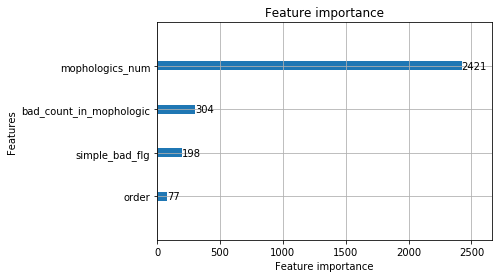

In [102]:
lgb.plot_importance(gbm)

In [27]:
# """
# 1対その他での学習
# """


# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# def vectorize(x_train,x_test, vec):
#     x_train_vec = vec.fit_transform(x_train.content)
#     x_test_vec = vec.transform(x_test.content)
    
#     x_train_vec = pd.DataFrame(x_train_vec.todense())
#     x_test_vec = pd.DataFrame(x_test_vec.todense())
    
#     x_train_vec["comment_id"]=x_train.comment_id.values
#     x_test_vec["comment_id"]=x_test.comment_id.values
    
#     return x_train_vec,x_test_vec



# def train_and_predict(df):

#     X = df.drop("target",axis=1)
#     y = df.target

#     x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
    
#     vec = TfidfVectorizer()
#     x_train_vec, x_test_vec = vectorize(x_train, x_test, vec)
#     train_content = pd.DataFrame(x_train.content.values, columns=["content"])
#     test_content  = pd.DataFrame(x_test.content.values, columns=["content"])
#     x_train.drop(["content"],axis=1,inplace=True)
#     x_test.drop(["content"],axis=1,inplace=True)
#     new_x_train = x_train.merge(x_train_vec, on="comment_id")#.drop('comment_id',axis=1)
#     new_x_test  = x_test.merge(x_test_vec, on="comment_id")#.drop('comment_id',axis=1)
#     new_x_train.drop('comment_id', axis=1, inplace=True)
#     new_x_test.drop('comment_id', axis=1, inplace=True)
#     x_train.drop(["comment_id"],axis=1,inplace=True)
#     x_test.drop(["comment_id"],axis=1,inplace=True)

#     svm = SVC(C=1.0, random_state=42)
#     vec_model = OneVsRestClassifier(svm)
#     vec_model.fit(new_x_train, y_train)
#     model = OneVsRestClassifier(svm)
#     model.fit(x_train, y_train)
#     print('fin')

#     return {
#         "pred_train_with_vec":  vec_model.predict(new_x_train),
#         "pred_test_with_vec": vec_model.predict(new_x_test),
#         "pred_train":model.predict(x_train),
#         "pred_test":model.predict(x_test),
#         "x_train":x_train,
#         "new_x_train":new_x_train,
#         "y_train":y_train,
#         "new_x_test":new_x_test,
#         "x_test":x_test,
#         "y_test":y_test,
#         "train_content":train_content,
#         "test_content":test_content,
# #         "x_train_vec":x_train_vec,
# #         "x_test_vec":x_test_vec
#     }

In [5]:
# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score
# import numpy as np
# '''
# mxm,ここでは3x3のマトリックスを作成する
# そこからf1値を計算する（同ディレクトリの画像参照）
# '''

# def create_3x3_matrix(true_y, pred_y):
#     matrix = np.zeros(9)

#     for t,p in zip(true_y, pred_y):
#         if t==0:
#             if p==0:matrix[0]+=1
#             if p==1:matrix[1]+=1
#             if p==2:matrix[2]+=1
#         elif t==1:
#             if p==0:matrix[3]+=1
#             if p==1:matrix[4]+=1
#             if p==2:matrix[5]+=1
#         elif t==2:
#             if p==0:matrix[6]+=1
#             if p==1:matrix[7]+=1
#             if p==2:matrix[8]+=1

#     return matrix.reshape(3,3)
# # matrix=create_3x3_matrix(y_train, pred_train)
# # matrix

In [7]:
# df1.to_csv('../data/clean/mount_data.csv', index=False)
# df1.to_excel('../data/clean/mount_data.xlsx', index=False)
# df1 = pd.read_excel('../data/clean/mount_data.xlsx')
# df1 = df1.dropna()
# df1["type"]=df1.target
# df1 = make_bad_feature(df1, badwordlist=badwordlist, positivelist=positivelist, hinikulist=hinikulist)

In [8]:
# df1[df1.target==0].shape[0], df1[df1.target==1].shape[0],df1[df1.target==2].shape[0]

In [27]:
# '''
# predのキー
# dict_keys(['pred_train', 'pred_test', 'x_train', 'new_x_train', 'y_train',\
# 'new_x_test', 'x_test', 'y_test', 'train_content', 'test_content'])
# '''

# def print_3x3miss_pred(pred, test=True, true_y=np.nan, pred_y=np.nan,df=np.nan):
#     if test:
#         true_y = pred["y_test"]
#         pred_y = pred["pred_test"]
#         df     = pred["test_content"]
#     else:
#         true_y = pred["y_train"]
#         pred_y = pred["pred_train"]
#         df     = pred["train_content"]


#     idx_arr = []
#     pred_judge=[]
#     true_judge=[]
#     for i in range(len(pred_y)):
#         if pred_y[i]!=true_y.values[i]:
# #             print(pred[i], true_y.values[i])
#             idx_arr.append(i)
#             pred_judge.append(pred_y[i])
#             true_judge.append(true_y.values[i])

#     def print_str_label(num):
#         if num==0:return "ニュートラル"
#         if num==1:return "悪口"
#         if num==2:return "皮肉"
#         return np.nan
    
#     col=["content","true_label_id","true_label","pred_label_id","pred_label"]
#     miss_data = pd.DataFrame(columns=col)
#     for i,idx in enumerate(idx_arr):
#         tmpdf = pd.DataFrame(np.array([df.iloc[idx].content, true_judge[i],\
#                                           print_str_label(true_judge[i]), pred_judge[i],\
#                                         print_str_label(pred_judge[i])]).reshape(1,-1),columns=col)
#         miss_data = pd.concat([miss_data, tmpdf])
        
# #             display(df.iloc[idx].content)
# #             print('true label  *',true_judge[i] , (print_str_label(true_judge[i])))
# #             print('pred label  *',pred_judge[i], (print_str_label(pred_judge[i])))
# #             print("------------------------------------------------------------------------------------")
        
#     print(miss_data.shape)
#     return miss_data

In [11]:
'''
他のベクトル変換の例

x_train,x_test, y_train, y_test = train_test_split(content, target, random_state=42)

・バイナリ
vec = CountVectorizer(binary=True)
train_and_val(x_train, x_test, y_train, y_test, vec)

・カウント
print('count')
vec = CountVectorizer(binary=False)
train_and_val(x_train, x_test, y_train, y_test, vec)


・TfIdf
vec = TfidfVectorizer()
vectorize(x_train, x_test, y_train, y_test, vec)

・bigram
vec = TfidfVectorizer(ngram_range=(1,3))
train_and_val(x_train, x_test, y_train, y_test, vec)
'''

"\n他のベクトル変換の例\n\nx_train,x_test, y_train, y_test = train_test_split(content, target, random_state=42)\n\n・バイナリ\nvec = CountVectorizer(binary=True)\ntrain_and_val(x_train, x_test, y_train, y_test, vec)\n\n・カウント\nprint('count')\nvec = CountVectorizer(binary=False)\ntrain_and_val(x_train, x_test, y_train, y_test, vec)\n\n\n・TfIdf\nvec = TfidfVectorizer()\nvectorize(x_train, x_test, y_train, y_test, vec)\n\n・bigram\nvec = TfidfVectorizer(ngram_range=(1,3))\ntrain_and_val(x_train, x_test, y_train, y_test, vec)\n"

In [12]:
df.head(2)

,content,mophologics_num,bad_per_mophologic,simple_bad_flg,target,hiniku_per_mophologic,simple_hiniku_flg,positive_per_mophologic,simple_positive_flg,comment_id
0,ガイジ,1,1,1,1,0,0,0,0,0
1,くどい,1,1,1,1,0,0,0,0,1


In [ ]:
pred = train_and_predict(df)

In [31]:
# print("no vectorize train")
# matrix=create_3x3_matrix(pred["y_train"], pred["pred_train"])
# print(matrix)
# print(calc_scores(matrix))
# print()
# print()
# print('no vectoizer test')
# matrix=create_3x3_matrix(pred["y_test"], pred["pred_test"])
# print(matrix)
# print(calc_scores(matrix))
# print()
# print()

# print("vectorize train")
# matrix=create_3x3_matrix(pred["y_train"], pred["pred_train_with_vec"])
# print(matrix)
# print(calc_scores(matrix))
# print()
# print()
# print('vectorize test')
# matrix=create_3x3_matrix(pred["y_test"], pred["pred_test_with_vec"])
# print(matrix)
# print(calc_scores(matrix))

no vectorize train
[[517.  22.  53.]
 [252. 448.  46.]
 [191.  49. 134.]]
{'recalls': array([0.87331081, 0.60053619, 0.35828877]), 'precisions': array([0.53854167, 0.86319846, 0.5751073 ]), 'f1': 0.6339142135942205}


no vectoizer test
[[129.  12.  14.]
 [ 64. 106.  16.]
 [ 47.  11.  29.]]
{'recalls': array([0.83225806, 0.56989247, 0.33333333]), 'precisions': array([0.5375    , 0.82170543, 0.49152542]), 'f1': 0.5970851886381953}


vectorize train
[[527.  19.  46.]
 [246. 482.  18.]
 [187.  38. 149.]]
{'recalls': array([0.8902027 , 0.6461126 , 0.39839572]), 'precisions': array([0.54895833, 0.89424861, 0.69953052]), 'f1': 0.6778058715586218}


vectorize test
[[130.   9.  16.]
 [ 65. 104.  17.]
 [ 45.  11.  31.]]
{'recalls': array([0.83870968, 0.55913978, 0.35632184]), 'precisions': array([0.54166667, 0.83870968, 0.484375  ]), 'f1': 0.6025906257243245}


In [271]:
v1 = model.wv["この"]
v2 = model.wv["殺す"]

cos_similarity(v1,v2)

0.6742897